In [79]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pickle

In [80]:
df = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv') #Import raw data
df = df.set_index('name') #Index each observation by the Car Model
df['owner'] = df['owner'].apply(lambda x:0 if x == "First Owner" else 1).astype(int) # 0 means one previous owner (car is on the newer side)
# 1 means two or more previous owner and car is on the older side. This definition seems clear and more simplified
df['fuel'] = df['fuel'].apply(lambda x:'Petrol' if x == 'Petrol' else ('Diesel' if x == 'Diesel' else 'Other'))
#Simplify fuel types into 3 categories. Any fuel type that isn't petrol/diesel make up <10% of the dataset and should be lumped as other instead
df = pd.get_dummies(df, columns = ['fuel','seller_type','transmission']) #Make dummy variables for categorical variables so we can model with the data
df['year'] = 2023 - df['year'] #Transform year column into a variable representing a car's age
df.columns.values[0] = 'Age'
owner = df.pop('owner') #Move owner column to front
df.insert(0,'owner',owner)
for i in ['Age','selling_price','km_driven']: #Standardize and scale these columns so k-NN will perform better
    df[i] = (df[i]-df[i].mean())/df[i].std()
ros = RandomOverSampler() #Balance the dataset
X_os, y_os = ros.fit_resample(df.iloc[:,1:], df.iloc[:,0])
X_os.insert(0,'Owners',y_os)
df = X_os
df

,Owners,Age,selling_price,km_driven,fuel_Diesel,fuel_Other,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual
0,0,1.444908,-0.767658,0.081130,0,0,1,0,1,0,0,1
1,0,1.444908,-0.638023,-0.347649,0,0,1,0,1,0,0,1
2,0,0.258765,0.165712,0.724298,1,0,0,0,1,0,0,1
3,0,-0.927378,-0.439250,-0.433405,0,0,1,0,1,0,0,1
4,1,-0.215692,-0.093557,1.603294,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5659,1,2.156594,-0.326900,0.938687,1,0,0,0,1,0,0,1
5660,1,0.495994,-0.439250,-0.237667,1,0,0,1,0,0,0,1
5661,1,-0.927378,-0.266403,0.081130,0,0,1,0,1,0,0,1
5662,1,0.970451,-0.439250,-0.090382,0,0,1,1,0,0,0,1


# k-NN (Best Classifcation Model)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0], test_size = .2, random_state = 0) #Split dataset

In [23]:
knn = KNeighborsClassifier(n_neighbors=1) #k-NN model
grid = GridSearchCV(knn, param_grid = {'n_neighbors':list(range(1,1000,2))}, n_jobs = -1) #Perform grid search to tune hyperparameter k
grid.fit(X_train,y_train)
print("Optimal Hyper-parameters : ", grid.best_params_)
print("Optimal Accuracy : ", grid.best_score_)

Optimal Hyper-parameters :  {'n_neighbors': 1}
Optimal Accuracy :  0.8216754163715618


In [67]:
Accuracy = {}
for i in range(1,1000,2): #Allow k to be odd to prevent ties #Compare accuracy among different k
    knn = KNeighborsClassifier(n_neighbors=i) 
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    Accuracy[i] = accuracy_score(y_test,y_pred)

In [72]:
k = np.array(list(Accuracy.keys())) #hyperparameter k
Acc = np.array(list(Accuracy.values())) #Corresponding Accuracy Values

[Text(0.5, 1.0, 'k-NN Accuracy Plot'),
 Text(0.5, 0, 'k'),
 Text(0, 0.5, 'Accuracy')]

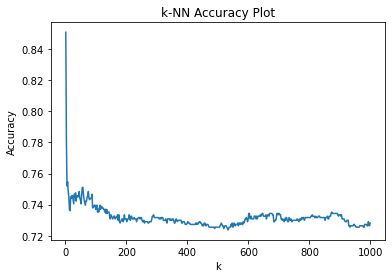

In [77]:
ax = sns.lineplot(x = k, y = Acc) #Visualize the values of k and their corresponding accuracy
ax.set(title = 'k-NN Accuracy Plot',xlabel = 'k',ylabel = 'Accuracy')

In [82]:
knn = KNeighborsClassifier(n_neighbors=1) #Model works best when k = 1 now fit the model
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84       583
           1       0.80      0.92      0.86       550

    accuracy                           0.85      1133
   macro avg       0.86      0.85      0.85      1133
weighted avg       0.86      0.85      0.85      1133



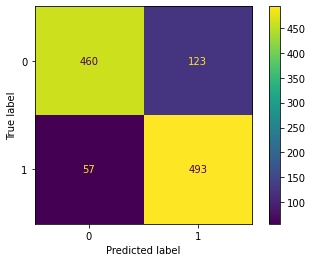

In [31]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
cm.plot()

In [32]:
CV = cross_validate(knn,df.iloc[:,1:], df.iloc[:,0], cv=10, scoring=['accuracy']) #Ensure model generalizes well by checking 10-fold CV
print('Accuracy')
print(CV['test_accuracy'])
print('Average Accuracy = ', sum(CV['test_accuracy']) / len(CV['test_accuracy']))

Accuracy
[0.80246914 0.8377425  0.84303351 0.80599647 0.77915194 0.90459364
 0.88339223 0.87809187 0.87102473 0.91696113]
Average Accuracy =  0.8522457170278136


In [83]:
pickle.dump(knn, open("knn.pkl", "wb"))

In [84]:
df.max(axis = 0)

Owners                           1.000000
Age                              5.003336
selling_price                   14.511954
km_driven                       15.873030
fuel_Diesel                      1.000000
fuel_Other                       1.000000
fuel_Petrol                      1.000000
seller_type_Dealer               1.000000
seller_type_Individual           1.000000
seller_type_Trustmark Dealer     1.000000
transmission_Automatic           1.000000
transmission_Manual              1.000000
dtype: float64

In [85]:
df.min(axis = 0)

Owners                          0.000000
Age                            -1.639064
selling_price                  -0.836796
km_driven                      -1.419574
fuel_Diesel                     0.000000
fuel_Other                      0.000000
fuel_Petrol                     0.000000
seller_type_Dealer              0.000000
seller_type_Individual          0.000000
seller_type_Trustmark Dealer    0.000000
transmission_Automatic          0.000000
transmission_Manual             0.000000
dtype: float64

# Logistic Regression

In [113]:
df = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv') #Import raw data
df = df.set_index('name') #Index each observation by the Car Model
df['owner'] = df['owner'].apply(lambda x:0 if x == "First Owner" else 1).astype(int) # 0 means one previous owner (car is on the newer side)
# 1 means two or more previous owner and car is on the older side. This definition seems clear and more simplified
df['fuel'] = df['fuel'].apply(lambda x:'Petrol' if x == 'Petrol' else ('Diesel' if x == 'Diesel' else 'Other'))
#Simplify fuel types into 3 categories. Any fuel type that isn't petrol/diesel make up <10% of the dataset and should be lumped as other instead
df = pd.get_dummies(df, columns = ['fuel','seller_type','transmission']) #Make dummy variables for categorical variables so we can model with the data
df['year'] = 2023 - df['year'] #Transform year column into a variable representing a car's age
df.columns.values[0] = 'Age'
owner = df.pop('owner') #Move owner column to front
df.insert(0,'owner',owner)
ros = RandomOverSampler() #Balance the dataset
X_os, y_os = ros.fit_resample(df.iloc[:,1:], df.iloc[:,0])
X_os.insert(0,'Owners',y_os)
df = X_os
for i in ['Age','selling_price','km_driven']: #Standardize and scale these columns so k-NN will perform better
    df[i] = (df[i]-df[i].mean())/df[i].std()
df = df.drop(columns = ['transmission_Automatic','seller_type_Dealer','fuel_Other']) #Drop some dummy variables so we
#have k - 1 variables for k levels and to prevent Singularity Issues

In [114]:
df

,Owners,Age,selling_price,km_driven,fuel_Diesel,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual
0,0,1.293836,-0.763019,-0.006599,0,1,1,0,1
1,0,1.293836,-0.621461,-0.432569,0,1,1,0,1
2,0,0.129100,0.256195,0.632355,1,0,1,0,1
3,0,-1.035636,-0.404406,-0.517762,0,1,1,0,1
4,1,-0.336795,-0.026920,1.505592,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...
5659,1,0.362047,-0.555401,-0.645553,0,1,1,0,1
5660,1,0.827942,-0.725270,0.419370,0,0,1,0,1
5661,1,1.526783,-0.696958,0.845339,0,1,1,0,1
5662,1,0.129100,-0.461029,-0.006599,1,0,1,0,1


In [115]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0], test_size = .2, random_state = 0) #Split dataset

              precision    recall  f1-score   support

           0       0.76      0.71      0.73       583
           1       0.71      0.76      0.74       550

    accuracy                           0.73      1133
   macro avg       0.74      0.74      0.73      1133
weighted avg       0.74      0.73      0.73      1133



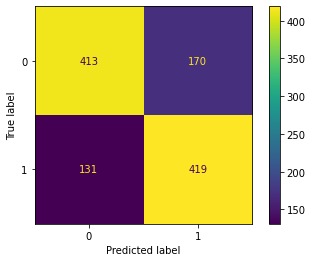

In [116]:
logreg = LogisticRegression() #Fit a logistic regression with default threshold
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test,y_pred))
cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)) #Make Confusion Matrix
cm.plot()

In [117]:
y_pred = logreg.predict_proba(X_test) 
y_pred = y_pred[::,1]#Extract sigmoid probabilities
fpr, tpr, _ = roc_curve(y_test,  y_pred) #Calculate fpr and tpr for each threshold to make roc curve
auc = roc_auc_score(y_test, y_pred) #Get AUC to evaulate model
auc #AUC of roughly .8 Model performs fairly well

0.7923545922345236

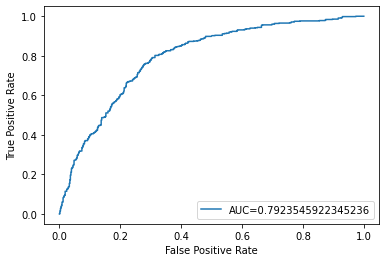

In [118]:
plt.plot(fpr,tpr,label="AUC="+str(auc)) #Plot ROC curve
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [119]:
optimal_idx = np.argmax(tpr - fpr) #Find the optimal threshold
optimal_threshold = _[optimal_idx]
optimal_threshold

0.4739625135794001

In [120]:
y_pred = (y_pred > optimal_threshold).astype(int) #Compare probabilites to optimal threshold for classification

In [121]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.69      0.73       583
           1       0.71      0.80      0.75       550

    accuracy                           0.74      1133
   macro avg       0.75      0.74      0.74      1133
weighted avg       0.75      0.74      0.74      1133



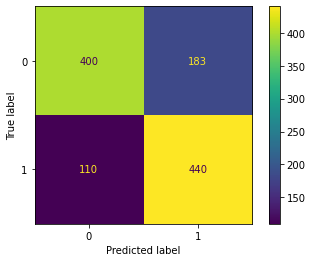

In [122]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)) #Make Confusion Matrix
cm.plot()

The optimal threshold is close to .5 so for simplicity sake, let's implement the built in .5 threshold model.

In [123]:
pickle.dump(logreg, open("logreg.pkl", "wb"))

In [124]:
df.max(axis = 0)

Owners                           1.000000
Age                              4.788045
selling_price                   15.921888
km_driven                       15.681830
fuel_Diesel                      1.000000
fuel_Petrol                      1.000000
seller_type_Individual           1.000000
seller_type_Trustmark Dealer     1.000000
transmission_Manual              1.000000
dtype: float64

In [125]:
df.min(axis = 0)

Owners                          0.000000
Age                            -1.734478
selling_price                  -0.838516
km_driven                      -1.497471
fuel_Diesel                     0.000000
fuel_Petrol                     0.000000
seller_type_Individual          0.000000
seller_type_Trustmark Dealer    0.000000
transmission_Manual             0.000000
dtype: float64